In [1]:
!pip install bs4
!pip install pythainlp

import requests
import re
import html
import json
from bs4 import BeautifulSoup
# from google.colab import files
import pandas as pd
# import numpy as np

     |████████████████████████████████| 11.1MB 74kB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 1.5MB 51.0MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449903 sha256=a865da26030cde90a2c04fcb69d5b2f5a0ac5a3b883695e93a70ea5f7bbdb10f
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
def getPostInfosFromContent(content):
    jsonDataArray = re.findall(r'\{\"result\"\:\{\"data.*?,\"variables', content)
    #ex. {"result": [get this result], "variables": [ignored]}
    posts = {}
    for jsonData in jsonDataArray:
        jsonData = jsonData[10: -31]
        try:
            data = json.loads(jsonData)['data']['feedback']
            commentsInfo = data['display_comments']['edges']
            comments = []
            for comment in commentsInfo:
                comment = comment['node']
                if comment['body'] is not None:
                    comments.append({
                        'id': comment['id'],
                        'time': comment['created_time'],
#                         'author': comment['author'], # deep information of user
                        'message': comment['body']['text'],
                        'like': comment['feedback']['reactors']['count']
                    })
            actorId = data['owning_profile']['id']
            postId = data['share_fbid']
            posts['{}_{}'.format(actorId, postId)] = {
                'like': data['reaction_count']['count'],
                'share': data['share_count']['count'],
                'comment': data['display_comments_count']['count'],
                'commentsHighlight': comments
            }
        except:
            continue
    return posts

In [0]:
def getPostsFromContent(content, postInfos):
    soup = BeautifulSoup(content, 'html.parser')
    divs = soup.find_all('div', {'class': '_5pcr userContentWrapper'})
    posts = []
    for div in divs:
        try:
            posts_id = div.find_all('div', {'class': '_5pcp _5lel _2jyu _232_'})
            posts_time = div.find_all('span', {'class': 'fsm fwn fcg'})
            posts_link = div.find_all('a', {'class': '_5pcq'})
            posts_text = div.find_all('div', {'class': '_5pbx userContent _3576'})
            postIds = [re.search(r'_[0-9]+;[0-9]+;', div['id']).group()[1:-1].replace(';', '_') for div in posts_id]
            postTimes = [int(span.abbr['data-utime']) for span in posts_time]
            postLinks = ['https://www.facebook.com' + a['href'] for a in posts_link]
            postMessages = []
            for div in posts_text:
                for span in div.find_all('span', {'class': 'text_exposed_hide'}):
                    span.decompose()
                for span in div.find_all('span', {'class': 'see_more_link_inner'}):
                    span.decompose()
                postMessages.append(div.get_text())
            posts.append({
                'id': postIds[0],
                'time': postTimes[0],
                'link': postLinks[0],
                'message': postMessages[0],
                'like': postInfos[postIds[0]]['like'],
                'share': postInfos[postIds[0]]['share'],
                'comment': postInfos[postIds[0]]['comment'],
                'commentsHighlight': postInfos[postIds[0]]['commentsHighlight']
            })
        except:
#             print('Exception')
            continue
    return posts

In [5]:
pageNameOrId = 'CH3Thailand' # <====== แก้ page name ตรงนี้ 638480949626833
source_url = 'https://www.facebook.com/pg/%s/posts/' % pageNameOrId
content = html.unescape(requests.get(source_url).text)
postInfos = getPostInfosFromContent(content)
posts = getPostsFromContent(content, postInfos)
urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
print(len(posts), posts[-1])

16 {'id': '1282973728458676_2744718872284147', 'time': 1582695011, 'link': 'https://www.facebook.com/Ch3Thailand/photos/a.1330600120362703/2744718025617565/?type=3', 'message': 'โชคชะตา นำพาให้พวกเขาได้มาพบกัน #ดั่งดวงหฤทัย เริ่มตอนแรก 5 มีนาคมนี้ #ช่อง3กด33 #Ch3Thailand', 'like': 719, 'share': 13, 'comment': 7, 'commentsHighlight': [{'id': 'Y29tbWVudDoyNzQ0NzE4ODcyMjg0MTQ3XzI3NDQ5MjkyOTIyNjMxMDU=', 'time': 1582697250, 'message': 'we are waiting!', 'like': 0}, {'id': 'Y29tbWVudDoyNzQ0NzE4ODcyMjg0MTQ3XzI3NDQ5NTA4OTg5Mjc2MTE=', 'time': 1582698372, 'message': 'ไม่ใช่สายน้ำแต่ฉ่ำชื่นหวาน\nไม่ใช่ลำธารที่ไหลผ่านหัวใจ\nไม่ใช่ดวงดาวแต่เธอเป็นดั่งดวงหฤทัยมีความหมายที่หามานาน🎶🎵🎙😆😊❤', 'like': 2}]}


In [0]:
content

'<!DOCTYPE html>\n<html lang="en" id="facebook" class="no_js">\n<head><meta charset="utf-8" /><meta name="referrer" content="default" id="meta_referrer" /><script>window._cstart=+new Date();</script><script>function envFlush(a){function b(b){for(var c in a)b[c]=a[c]}window.requireLazy?window.requireLazy(["Env"],b):(window.Env=window.Env||{},b(window.Env))}envFlush({"ajaxpipe_token":"AXibKnQIbaOjUNwK","timeslice_heartbeat_config":{"pollIntervalMs":33,"idleGapThresholdMs":60,"ignoredTimesliceNames":{"requestAnimationFrame":true,"Event listenHandler mousemove":true,"Event listenHandler mouseover":true,"Event listenHandler mouseout":true,"Event listenHandler scroll":true},"isHeartbeatEnabled":true,"isArtilleryOn":false},"shouldLogCounters":true,"timeslice_categories":{"react_render":true,"reflow":true},"sample_continuation_stacktraces":true,"dom_mutation_flag":true,"stack_trace_limit":30,"deferred_stack_trace_rate":1000,"timesliceBufferSize":5000,"show_invariant_decoder":false,"compat_ifra

In [6]:
# for i in range(5):
  while True:
    try:
        next_url = 'https://www.facebook.com%s&__a=1' % urlResult
        tmp_content = requests.get(next_url).text[9:]
        next_content = json.loads(tmp_content)
        content = html.unescape(next_content['domops'][0][3]['__html'])
        postInfos = getPostInfosFromContent(tmp_content)
        next_posts = getPostsFromContent(content, postInfos)
        posts += next_posts
        try:
            urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
        except:
            print('end')
            break
    except:
        print(next_url)
        continue
print(len(posts), posts[-1])

end
2244 {'id': '1282973728458676_1331975420225173', 'time': 1496390158, 'link': 'https://www.facebook.com/Ch3Thailand/videos/1331975420225173/', 'message': 'พร้อมรึยัง? ได้เวลาตามหารักแท้ ระหว่าง ทันตแพทย์หนุ่มหล่อผู้ร่ำรวย และ พนักงานฝ่ายการเงินประจำบริษัทคิวปิดฮัต เจ้าของฉายา "เกลือเรียกแม่" แตกต่างกันสุดขั้วขนาดนี้ แล้วความรักของทั้งคู่จะลงเอยกันได้อย่างไร! ติดตามได้ใน #กามเทพซ้อนกล ตอนแรก! เสาร์ที่ 3 มิ.ย. เวลา 20.15 น. ทางช่อง 3, 33 #หมอหล่อบอกต่อด้วย', 'like': 80, 'share': 12, 'comment': 0, 'commentsHighlight': []}


In [0]:
#df = pd.DataFrame(posts)
#df = df[['id', 'time', 'link', 'message', 'like', 'share', 'comment', 'commentsHighlight']]
#for i in range(len(df)):
#    df['commentsHighlight'][i] = pd.DataFrame(df['commentsHighlight'][i])
#    if len(df['commentsHighlight'][i]) > 0 :
#        df['commentsHighlight'][i] = df['commentsHighlight'][i][['id', 'time', 'message', 'like']]
# # print(df[:5])

In [0]:
df = pd.DataFrame(posts)
df = df[['id', 'time', 'link', 'message', 'like', 'share', 'comment', 'commentsHighlight']]
df['time']=pd.to_datetime(df['time'],unit='s')
df.to_csv(pageNameOrId+'.csv')
from google.colab import files
files.download(pageNameOrId+'.csv')

In [8]:
hashtag_df=pd.DataFrame(dict({'created_time':[], 'hashtag':[], 'likes':[]}), dtype=int)
for index,row in df.iterrows():
  tokens = row['message'].split()
  hashtags = [token for token in tokens if token[0] == '#']
  for hashtag in hashtags:
    hashtag_record = {'created_time':row['time'],'hashtag':hashtag,'likes':row['like']}
    hashtag_df=hashtag_df.append(hashtag_record,ignore_index=True)
hashtag_df

,created_time,hashtag,likes
0,2020-02-26 15:04:33,#ฟ้าฝากรัก,440
1,2020-02-26 15:04:33,#ช่อง3กด33,440
2,2020-02-26 15:04:33,#Ch3Thailand,440
3,2020-02-26 14:13:31,#ฟ้าฝากรัก,544
4,2020-02-26 14:13:31,#ช่อง3กด33,544
...,...,...,...
6776,2017-06-03 02:30:38,#วันนี้เสนอเป็นตอนแรก,67
6777,2017-06-03 02:30:38,#ช่อง33,67
6778,2017-06-03 02:30:38,#ch3thailand,67
6779,2017-06-02 07:55:58,#กามเทพซ้อนกล,80


In [9]:
!pip install wordcloud
hashtag_df['created_time']=pd.to_datetime(hashtag_df['created_time'])
sum_df=hashtag_df.groupby('hashtag').sum().sort_values(by=['likes'],ascending=False)['likes']
sum_df

hashtag
#Ch3Thailand                      8556937
#ช่อง3กด33                        2986217
#บุพเพสันนิวาส                    2935810
#ซ่อนเงารัก                       1150947
#ผมอาถรรพ์                         709683
                                   ...   
#mello                                 37
#จุดพลังใจ                             33
#ทายาทสโนไวท์กับคนแคระทั้งเจ็ด         29
#อโศกมหาราช                            29
#news                                  24
Name: likes, Length: 839, dtype: int64

(-0.5, 599.5, 399.5, -0.5)

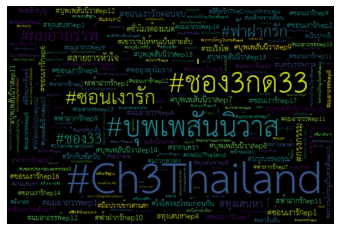

In [11]:
#sum_df.to_dict()
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wd=WordCloud(font_path='THSarabunNew.ttf',width=600, height=400).generate_from_frequencies(sum_df)
plt.imshow(wd, interpolation='bilinear')
plt.axis('off')

In [0]:
hashtag_df.to_csv(pageNameOrId+'_hashtag.csv')
files.download(pageNameOrId+'_hashtag.csv')

### The end of NSTDA sample

In [0]:
from google.colab import files
files.upload() # upload file THSarabunNew.ttf 

In [0]:
!pip install wordcloud

hashtag_df['created_time']=pd.to_datetime(hashtag_df['created_time'])
sum_df=hashtag_df.groupby('hashtag').sum().sort_values(by=['likes'],ascending=False)['likes']
sum_df


In [0]:
from google.colab import files
files.upload()

In [0]:
#sum_df.to_dict()
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wd=WordCloud(font_path='THSarabunNew.ttf',width=800, height=600).generate_from_frequencies(sum_df.to_dict())
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")